[OK] Saved 300 signals for class N → dataset_ecg/N/
[OK] Saved 300 signals for class S → dataset_ecg/S/
[OK] Saved 300 signals for class V → dataset_ecg/V/
[OK] Saved 300 signals for class F → dataset_ecg/F/
[OK] Saved 300 signals for class Q → dataset_ecg/Q/

Dataset generation complete.
Plot preview disimpan sebagai 'preview_ecg_per_class.png'


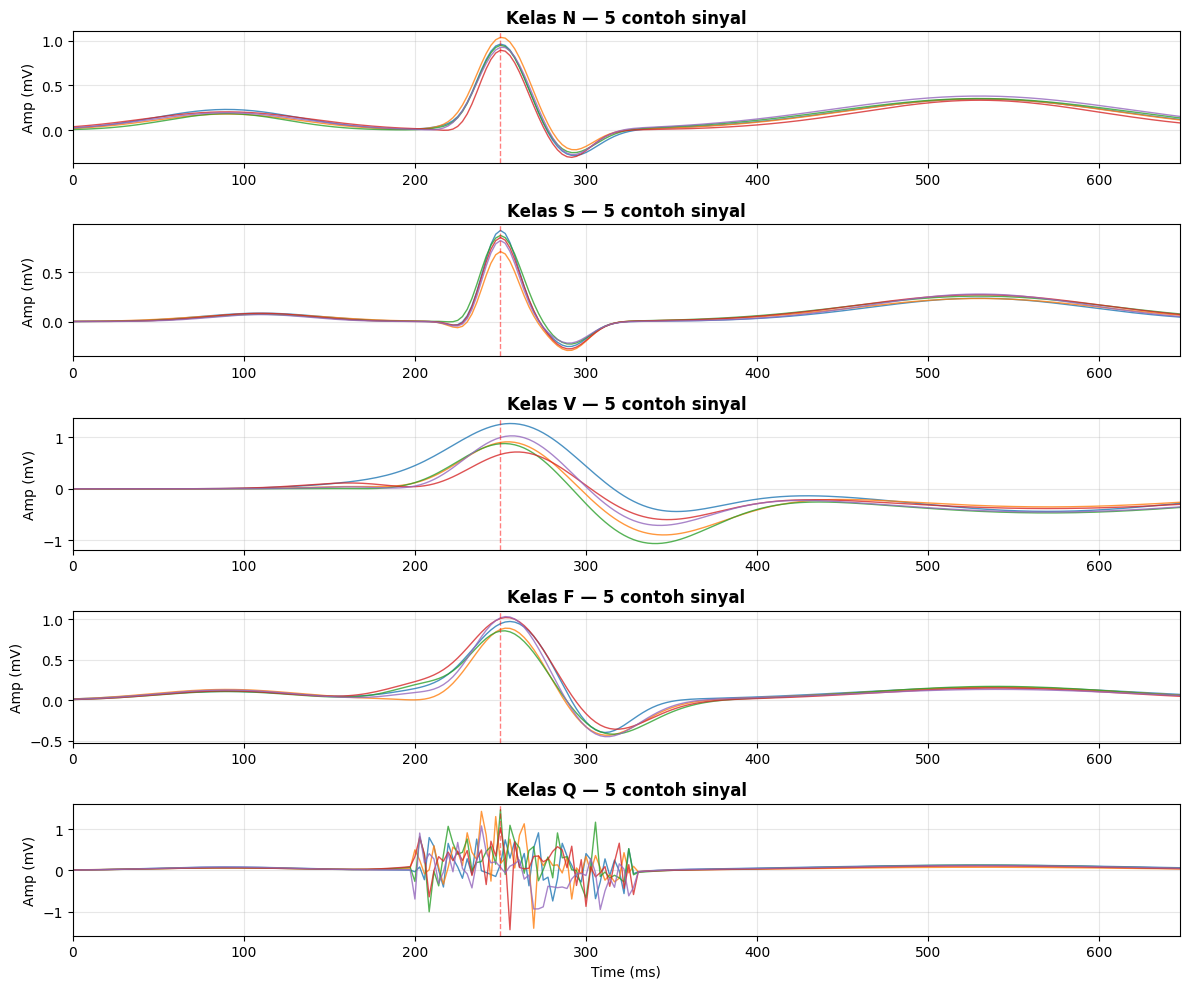

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Dict, Tuple


# ============================================================
# 1. Gaussian util
# ============================================================
def gauss(t: np.ndarray, mu: float, sigma: float, amp: float) -> np.ndarray:
    if sigma <= 0:
        return np.zeros_like(t)
    return amp * np.exp(-0.5 * ((t - mu) / sigma) ** 2)


# ============================================================
# 2. Artefak noise khusus QRS untuk kelas Q
# ============================================================
def add_qrs_artifact_noise(
    t: np.ndarray,
    t_r: float,
    base_signal: np.ndarray,
    noise_level: float = 0.35,
    spike_scale: float = 0.9,
) -> np.ndarray:
    """
    Tambahkan artefak noise di sekitar kompleks QRS supaya morfologi
    sulit dikenali (benar-benar 'unknown').
    """
    artifact = np.zeros_like(base_signal)

    # Window sekitar QRS (50 ms sebelum R sampai 80 ms sesudah R)
    qrs_window_start = t_r - 0.050
    qrs_window_end   = t_r + 0.080
    mask = (t >= qrs_window_start) & (t <= qrs_window_end)
    idx = np.where(mask)[0]

    if idx.size > 0:
        # High frequency noise di sekitar QRS
        artifact[idx] += noise_level * np.random.randn(idx.size)

        # Tambahkan beberapa spike tajam (positif / negatif)
        n_spikes = np.random.randint(2, 5)  # 2–4 spike
        spike_idx = np.random.choice(idx, size=min(n_spikes, idx.size), replace=False)
        spike_sign = np.random.choice([-1.0, 1.0], size=spike_idx.size)
        spike_amp = spike_scale * (0.5 + np.random.rand(spike_idx.size))  # 0.5–1.3
        artifact[spike_idx] += spike_sign * spike_amp

    return base_signal + artifact


# ============================================================
# 3. Template beat per kelas dengan amplitude & sigma jitter
# ============================================================
def generate_beat_template(
    t: np.ndarray,
    cls: str,
    r_time: float = 0.25,
) -> np.ndarray:
    """
    Generate beat sintetis dengan morfologi AAMI yang valid.

    - Posisi P/Q/R/S/T FIX (tidak digeser).
    - Randomness hanya di amplitude & sigma.
    - Noise hanya pada kelas Q di sekitar QRS.
    """
    cls = cls.upper()

    # Posisi komponen relatif ke R
    t_r = r_time
    t_p = t_r - 0.160
    t_q = t_r - 0.020
    t_s = t_r + 0.040
    t_t = t_r + 0.280

    if cls == "N":
        params = {
            "p_amp": 0.20, "p_sigma": 0.040,
            "q_amp": -0.15, "q_sigma": 0.010,
            "r_amp": 1.00, "r_sigma": 0.015,
            "s_amp": -0.30, "s_sigma": 0.015,
            "t_amp": 0.35, "t_sigma": 0.080,
        }

    elif cls == "S":
        t_p = t_r - 0.140
        params = {
            "p_amp": 0.08, "p_sigma": 0.035,
            "q_amp": -0.12, "q_sigma": 0.008,
            "r_amp": 0.85, "r_sigma": 0.012,
            "s_amp": -0.25, "s_sigma": 0.012,
            "t_amp": 0.25, "t_sigma": 0.070,
        }

    elif cls == "V":
        t_q = t_r - 0.035
        t_s = t_r + 0.080
        t_t = t_r + 0.320
        params = {
            "p_amp": 0.0,   "p_sigma": 0.040,  # no P wave
            "q_amp": -0.70, "q_sigma": 0.030,
            "r_amp": 1.40,  "r_sigma": 0.045,
            "s_amp": -1.00, "s_sigma": 0.040,
            "t_amp": -0.40, "t_sigma": 0.100,  # inverted T
        }

    elif cls == "F":
        t_q = t_r - 0.025
        t_s = t_r + 0.055
        t_t = t_r + 0.290
        params = {
            "p_amp": 0.12, "p_sigma": 0.038,
            "q_amp": -0.40, "q_sigma": 0.018,
            "r_amp": 1.15, "r_sigma": 0.028,
            "s_amp": -0.55, "s_sigma": 0.025,
            "t_amp": 0.15, "t_sigma": 0.085,
        }

    elif cls == "Q":
        params = {
            "p_amp": 0.06, "p_sigma": 0.045,
            "q_amp": -0.18, "q_sigma": 0.020,
            "r_amp": 0.50, "r_sigma": 0.025,
            "s_amp": -0.22, "s_sigma": 0.025,
            "t_amp": 0.12, "t_sigma": 0.090,
        }

    else:
        raise ValueError(f"Kelas '{cls}' tidak dikenal. Gunakan N/S/V/F/Q.")

    # -------- Jitter amplitude & sigma (tanpa geser waktu) --------
    amp_jitter_scale_per_class = {
        "N": 0.08,
        "S": 0.10,
        "V": 0.12,
        "F": 0.10,
        "Q": 0.18,
    }
    amp_scale = amp_jitter_scale_per_class.get(cls, 0.10)
    width_jitter_scale = 0.10

    for key in ["p_amp", "q_amp", "r_amp", "s_amp", "t_amp"]:
        base = params[key]
        if base != 0.0:
            eps = np.random.normal(0.0, amp_scale)
            eps = float(np.clip(eps, -0.4, 0.4))  # -40% s/d +40%
            params[key] = base * (1.0 + eps)

    for key in ["p_sigma", "q_sigma", "r_sigma", "s_sigma", "t_sigma"]:
        base = params[key]
        if base > 0.0:
            eps = np.random.normal(0.0, width_jitter_scale)
            eps = float(np.clip(eps, -0.4, 0.4))
            new_sigma = base * (1.0 + eps)
            params[key] = max(new_sigma, 0.003)  # minimal 3 ms

    # ---- Bangun sinyal P-QRS-T ----
    p      = gauss(t, t_p, params["p_sigma"], params["p_amp"])
    q      = gauss(t, t_q, params["q_sigma"], params["q_amp"])
    r      = gauss(t, t_r, params["r_sigma"], params["r_amp"])
    s      = gauss(t, t_s, params["s_sigma"], params["s_amp"])
    t_wave = gauss(t, t_t, params["t_sigma"], params["t_amp"])

    beat = p + q + r + s + t_wave

    # Artefak khusus Q
    if cls == "Q":
        beat = add_qrs_artifact_noise(
            t=t,
            t_r=t_r,
            base_signal=beat,
            noise_level=0.35,
            spike_scale=0.9,
        )

    return beat


# ============================================================
# 4. Generate dataset dan simpan ke directory per kelas
# ============================================================
def save_ecg_dataset(
    out_dir: str,
    num_per_class: Dict[str, int],
    fs: int = 360,
    duration: float = 0.65,
    r_time: float = 0.25,
):
    """
    Simpan setiap beat sebagai file .npz:
      - signal: (T,)
      - t     : (T,)
      - label : str
    """
    t = np.arange(0, duration, 1.0 / fs)
    os.makedirs(out_dir, exist_ok=True)

    for cls, n in num_per_class.items():
        cls = cls.upper()
        cls_dir = os.path.join(out_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)

        for i in range(n):
            signal = generate_beat_template(t, cls, r_time=r_time).astype(np.float32)
            filename = os.path.join(cls_dir, f"beat_{i:04d}.npz")
            np.savez(filename, signal=signal, t=t, label=cls)

        print(f"[OK] Saved {n} signals for class {cls} → {cls_dir}/")

    print("\nDataset generation complete.")


# ============================================================
# 5. Plot beberapa contoh amplitude per kelas dari .npz
# ============================================================
def plot_class_examples(
    base_dir: str,
    classes = ("N", "S", "V", "F", "Q"),
    n_examples: int = 5,
    r_time: float = 0.25,
):
    """
    Plot beberapa contoh sinyal per kelas dari file .npz di base_dir.

    - n_examples: banyaknya beat yang dioverlay per kelas.
    """
    classes = [c.upper() for c in classes]

    plt.figure(figsize=(12, 10))

    for i, cls in enumerate(classes, start=1):
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_dir):
            print(f"[WARN] Folder untuk kelas {cls} tidak ditemukan, skip.")
            continue

        files = sorted(
            [f for f in os.listdir(cls_dir) if f.endswith(".npz")]
        )
        if not files:
            print(f"[WARN] Tidak ada file .npz di {cls_dir}, skip.")
            continue

        # Ambil sampai n_examples pertama (atau kurang kalau file sedikit)
        files = files[:min(n_examples, len(files))]

        plt.subplot(len(classes), 1, i)

        for fname in files:
            data = np.load(os.path.join(cls_dir, fname))
            sig = data["signal"]
            t = data["t"] * 1000.0  # ke ms

            plt.plot(t, sig, linewidth=1.0, alpha=0.8)

        # Garis posisi R
        plt.axvline(r_time * 1000.0, linestyle="--", linewidth=1,
                    color="red", alpha=0.5)

        plt.ylabel("Amp (mV)")
        plt.grid(True, alpha=0.3)
        plt.xlim(t.min(), t.max())
        plt.title(f"Kelas {cls} — {len(files)} contoh sinyal", fontweight="bold")

        if i == len(classes):
            plt.xlabel("Time (ms)")

    plt.tight_layout()
    plt.savefig("preview_ecg_per_class.png", dpi=150, bbox_inches="tight")
    print("Plot preview disimpan sebagai 'preview_ecg_per_class.png'")
    plt.show()


# ============================================================
# 6. Example usage
# ============================================================
if __name__ == "__main__":
    # Optional: set seed kalau mau reproducible
    # np.random.seed(42)

    num_per_class = {
        "N": 300,
        "S": 300,
        "V": 300,
        "F": 300,
        "Q": 300,
    }

    out_dir = "dataset_ecg"
    fs = 360
    duration = 0.65
    r_time = 0.25

    # Generate & simpan dataset
    save_ecg_dataset(
        out_dir=out_dir,
        num_per_class=num_per_class,
        fs=fs,
        duration=duration,
        r_time=r_time,
    )

    # Plot beberapa contoh amplitude per kelas
    plot_class_examples(
        base_dir=out_dir,
        classes=("N", "S", "V", "F", "Q"),
        n_examples=5,
        r_time=r_time,
    )
